In [3]:
from flask import Flask, render_template
app = Flask(__name__)

@app.route('/')
def home():
    return render_template('index.html')

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

C:\Users\MAYANK PUVVALA\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3556: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


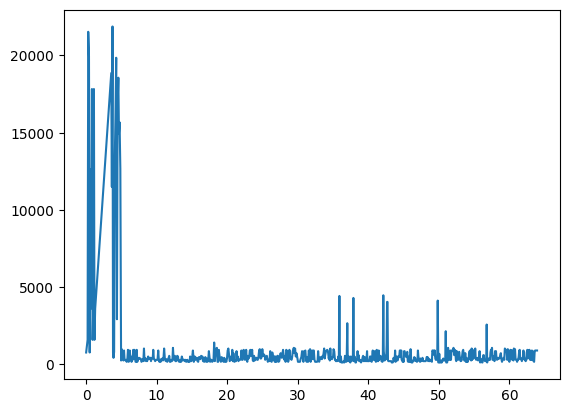

Exception in thread Thread-6 (detect_frequency):
Traceback (most recent call last):
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Temp\ipykernel_11052\2126693165.py", line 105, in detect_frequency
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 11, in draw
    self.blit()
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 14, in blit
    _backend_tk.blit(self._tkphot

In [1]:
import tkinter as tk
from tkinter import messagebox
import cv2
import dlib
import scipy.spatial
import imutils
import pyaudio
import numpy as np
import threading
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import time

# Initialize PyAudio
p = pyaudio.PyAudio()

# Open stream
stream = p.open(format=pyaudio.paInt16, channels=1, rate=44100, input=True, frames_per_buffer=1024)

# Initialize frequency and time lists
freq_list = []
time_list = []


def calculate_EAR(eye):
    A = scipy.spatial.distance.euclidean(eye[1], eye[5])
    B = scipy.spatial.distance.euclidean(eye[2], eye[4])
    C = scipy.spatial.distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear
    
def detect_drowsiness():
    cap = cv2.VideoCapture(0)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    while True:
        _, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)
            leftEye = []
            rightEye = []
            for n in range(36, 42):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                leftEye.append((x, y))
                next_point = n + 1
                if n == 41:
                    next_point = 36
                x2 = landmarks.part(next_point).x
                y2 = landmarks.part(next_point).y
                cv2.line(frame, (x, y), (x2, y2), (0, 255, 0), 1)
            for n in range(42, 48):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                rightEye.append((x, y))
                next_point = n + 1
                if n == 47:
                    next_point = 42
                x2 = landmarks.part(next_point).x
                y2 = landmarks.part(next_point).y
                cv2.line(frame, (x, y), (x2, y2), (0, 255, 0), 1)
            leftEAR = calculate_EAR(leftEye)
            rightEAR = calculate_EAR(rightEye)
            EAR = (leftEAR + rightEAR) / 2
            EAR = round(EAR, 2)
            if EAR < 0.26:
                cv2.putText(frame, "Sleepy", (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                cv2.putText(frame, "Prediction: Inactive", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            else:
                cv2.putText(frame, "Prediction: Active", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(frame, "EAR: {:.2f}".format(EAR), (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        cv2.imshow("Drowsiness Detection", frame)
        key = cv2.waitKey(1)
        if key == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

def detect_frequency():
    global freq_list, time_list
    start_time = time.time()
    while True:
        # Read data from the audio input
        data = np.frombuffer(stream.read(1024), dtype=np.int16)

        # Perform FFT on the data
        fft_data = np.fft.rfft(data)

        # Calculate the frequencies in the data
        freq = np.fft.rfftfreq(len(data), 1.0 / 44100)

        # Find the peak frequency
        peak_freq = freq[np.argmax(np.abs(fft_data))]

        # Append the peak frequency and current time to the lists
        freq_list.append(peak_freq)
        time_list.append(time.time() - start_time)

        # Update the plot
        ax.clear()
        ax.plot(time_list, freq_list)
        canvas.draw()

root = tk.Tk()
root.title("Drowsiness Detection")

frame = tk.Frame(root)
frame.pack()

button = tk.Button(frame, 
                   text="Check Drowsiness", 
                   fg="red",
                   command=detect_drowsiness)
button.pack(side=tk.LEFT)

# Create a figure and a plot
fig, ax = plt.subplots()
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=tk.RIGHT, fill=tk.BOTH, expand=1)

# Start drowsiness detection and frequency detection in separate threads
threading.Thread(target=detect_drowsiness, daemon=True).start()
threading.Thread(target=detect_frequency, daemon=True).start()

root.mainloop()


In [1]:
import tkinter as tk
from tkinter import messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import cv2
import dlib, pyaudio
import scipy.spatial
import numpy as np
import threading
import time
import matplotlib.pyplot as plt
from PIL import Image, ImageTk

# Initialize PyAudio
p = pyaudio.PyAudio()

# Open stream
stream = p.open(format=pyaudio.paInt16, channels=1, rate=44100, input=True, frames_per_buffer=1024)

# Initialize frequency and time lists
freq_list = []
time_list = []
high_freq_start_time = None
freq_lock = threading.Lock()
time_lock = threading.Lock()

def calculate_EAR(eye):
    A = scipy.spatial.distance.euclidean(eye[1], eye[5])
    B = scipy.spatial.distance.euclidean(eye[2], eye[4])
    C = scipy.spatial.distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def detect_drowsiness(canvas):
    cap = cv2.VideoCapture(0)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    while True:
        _, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)
            leftEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
            rightEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
            leftEAR = calculate_EAR(leftEye)
            rightEAR = calculate_EAR(rightEye)
            EAR = (leftEAR + rightEAR) / 2
            EAR = round(EAR, 2)
            if EAR < 0.26:
                cv2.putText(frame, "Sleepy", (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                cv2.putText(frame, "Prediction: Inactive", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            else:
                cv2.putText(frame, "Prediction: Active", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(frame, "EAR: {:.2f}".format(EAR), (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        # Display the frame on the Tkinter window
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (400, 300))
        img = Image.fromarray(img)
        img = ImageTk.PhotoImage(image=img)
        canvas.create_image(0, 0, anchor=tk.NW, image=img)
        canvas.image = img

        key = cv2.waitKey(1)
        if key == ord('e'):  # Exit on 'e' key
            break
    cap.release()
    cv2.destroyAllWindows()

def detect_frequency():
    global freq_list, time_list, high_freq_start_time
    start_time = time.time()
    first_second_skipped = False
    while True:
        data = np.frombuffer(stream.read(1024), dtype=np.int16)
        fft_data = np.fft.rfft(data)
        freq = np.fft.rfftfreq(len(data), 1.0 / 44100)
        peak_freq = freq[np.argmax(np.abs(fft_data))]
        if np.max(np.abs(fft_data)) > 10000:
            with freq_lock, time_lock:
                # Skip the first second
                if not first_second_skipped and time.time() - start_time > 1:
                    first_second_skipped = True
                if first_second_skipped:
                    freq_list.append(peak_freq)
                    time_list.append(time.time() - start_time)
                # Check for high frequency
                if peak_freq > 1000 and high_freq_start_time is None:
                    high_freq_start_time = time.time()
                elif peak_freq <= 1000:
                    high_freq_start_time = None
        time.sleep(0.1)

def update_duration_label(label):
    while True:
        if high_freq_start_time is not None:
            duration = time.time() - high_freq_start_time
            label.config(text=f"High Frequency Duration: {duration:.2f} seconds")
        else:
            label.config(text="High Frequency Duration: 0.00 seconds")
        time.sleep(0.1)

root = tk.Tk()
root.title("Drowsiness Detection")

frame = tk.Frame(root)
frame.pack()

# Create canvases for displaying different sections
canvas1 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas1.grid(row=0, column=0, padx=5, pady=5)

canvas2 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas2.grid(row=0, column=1, padx=5, pady=5)

canvas3 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas3.grid(row=1, column=0, padx=5, pady=5)

canvas4 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas4.grid(row=1, column=1, padx=5, pady=5)

# Start drowsiness detection and frequency detection in separate threads
threading.Thread(target=detect_drowsiness, args=(canvas1,), daemon=True).start()
threading.Thread(target=detect_frequency, daemon=True).start()
threading.Thread(target=update_duration_label, args=(canvas3,), daemon=True).start()

root.mainloop()


Exception in thread Thread-7 (update_duration_label):
Traceback (most recent call last):
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Temp\ipykernel_13424\3787470369.py", line 100, in update_duration_label
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 1675, in configure
    return self._configure('configure', cnf, kw)
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 1665, in _configure
    self.tk.call(_flatten((self._w, c

In [2]:
import tkinter as tk
import cv2, pyaudio
import dlib
import scipy.spatial
import numpy as np
import threading
import time
import pyaudio
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk

# Initialize PyAudio
p = pyaudio.PyAudio()

# Open stream
stream = p.open(format=pyaudio.paInt16, channels=1, rate=44100, input=True, frames_per_buffer=1024)

# Initialize frequency and time lists
freq_list = []
time_list = []
high_freq_start_time = None
freq_lock = threading.Lock()
time_lock = threading.Lock()

def calculate_EAR(eye):
    A = scipy.spatial.distance.euclidean(eye[1], eye[5])
    B = scipy.spatial.distance.euclidean(eye[2], eye[4])
    C = scipy.spatial.distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def detect_drowsiness(canvas):
    cap = cv2.VideoCapture(0)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    while True:
        _, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)
            leftEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
            rightEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
            leftEAR = calculate_EAR(leftEye)
            rightEAR = calculate_EAR(rightEye)
            EAR = (leftEAR + rightEAR) / 2
            EAR = round(EAR, 2)
            if EAR < 0.26:
                cv2.putText(frame, "Sleepy", (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                cv2.putText(frame, "Prediction: Inactive", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            else:
                cv2.putText(frame, "Prediction: Active", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(frame, "EAR: {:.2f}".format(EAR), (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        # Display the frame on the Tkinter window
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (400, 300))
        img = Image.fromarray(img)
        img = ImageTk.PhotoImage(image=img)
        canvas.create_image(0, 0, anchor=tk.NW, image=img)
        canvas.image = img

        key = cv2.waitKey(1)
        if key == ord('e'):  # Exit on 'e' key
            break
    cap.release()
    cv2.destroyAllWindows()

def detect_frequency():
    global freq_list, time_list, high_freq_start_time
    start_time = time.time()
    first_second_skipped = False
    while True:
        data = np.frombuffer(stream.read(1024), dtype=np.int16)
        fft_data = np.fft.rfft(data)
        freq = np.fft.rfftfreq(len(data), 1.0 / 44100)
        peak_freq = freq[np.argmax(np.abs(fft_data))]
        if np.max(np.abs(fft_data)) > 10000:
            with freq_lock, time_lock:
                # Skip the first second
                if not first_second_skipped and time.time() - start_time > 1:
                    first_second_skipped = True
                if first_second_skipped:
                    freq_list.append(peak_freq)
                    time_list.append(time.time() - start_time)
                # Check for high frequency
                if peak_freq > 1000 and high_freq_start_time is None:
                    high_freq_start_time = time.time()
                elif peak_freq <= 1000:
                    high_freq_start_time = None
        time.sleep(0.1)

def update_duration_label(label):
    while True:
        if high_freq_start_time is not None:
            duration = time.time() - high_freq_start_time
            label.config(text=f"High Frequency Duration: {duration:.2f} seconds")
        else:
            label.config(text="High Frequency Duration: 0.00 seconds")
        time.sleep(0.1)

root = tk.Tk()
root.title("Machine Knight")

frame = tk.Frame(root)
frame.pack()

canvas1 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas1.grid(row=0, column=0, padx=5, pady=5)

canvas2 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas2.grid(row=0, column=1, padx=5, pady=5)

canvas3 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas3.grid(row=1, column=0, padx=5, pady=5)

canvas4 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas4.grid(row=1, column=1, padx=5, pady=5)

label3 = tk.Label(canvas3, text="Voice Count: ", font=("Helvetica", 12))
label3.pack(pady=10)

threading.Thread(target=detect_drowsiness, args=(canvas1,), daemon=True).start()
threading.Thread(target=detect_frequency, daemon=True).start()
threading.Thread(target=update_duration_label, args=(label3,), daemon=True).start()

root.bind('e', lambda event: root.destroy())  # Exit on 'e' key

root.mainloop()
#frequency is not working so, taking realtime input data from my mic. drowsiness, boxes works fine. 

: 

In [1]:
import tkinter as tk
import cv2
import dlib
import scipy.spatial
import numpy as np
import threading
import time
import sounddevice as sd  # Import the sounddevice library
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk

# Initialize frequency and time lists
freq_list = []
time_list = []
high_freq_start_time = None
freq_lock = threading.Lock()
time_lock = threading.Lock()

def calculate_EAR(eye):
    A = scipy.spatial.distance.euclidean(eye[1], eye[5])
    B = scipy.spatial.distance.euclidean(eye[2], eye[4])
    C = scipy.spatial.distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def detect_drowsiness(canvas):
    cap = cv2.VideoCapture(0)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    while True:
        _, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)
            leftEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
            rightEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
            leftEAR = calculate_EAR(leftEye)
            rightEAR = calculate_EAR(rightEye)
            EAR = (leftEAR + rightEAR) / 2
            EAR = round(EAR, 2)
            if EAR < 0.26:
                cv2.putText(frame, "Sleepy", (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                cv2.putText(frame, "Prediction: Inactive", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            else:
                cv2.putText(frame, "Prediction: Active", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(frame, "EAR: {:.2f}".format(EAR), (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        # Display the frame on the Tkinter window
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (400, 300))
        img = Image.fromarray(img)
        img = ImageTk.PhotoImage(image=img)
        canvas.create_image(0, 0, anchor=tk.NW, image=img)
        canvas.image = img

        key = cv2.waitKey(1)
        if key == ord('e'):  # Exit on 'e' key
            break
    cap.release()
    cv2.destroyAllWindows()

def detect_frequency():
    global freq_list, time_list, high_freq_start_time
    start_time = time.time()
    first_second_skipped = False
    while True:
        data, _ = sd.read(1024)  # Use sounddevice to capture audio from the microphone
        fft_data = np.fft.rfft(data)
        freq = np.fft.rfftfreq(len(data), 1.0 / 44100)
        peak_freq = freq[np.argmax(np.abs(fft_data))]
        if np.max(np.abs(fft_data)) > 10000:
            with freq_lock, time_lock:
                # Skip the first second
                if not first_second_skipped and time.time() - start_time > 1:
                    first_second_skipped = True
                if first_second_skipped:
                    freq_list.append(peak_freq)
                    time_list.append(time.time() - start_time)
                # Check for high frequency
                if peak_freq > 1000 and high_freq_start_time is None:
                    high_freq_start_time = time.time()
                elif peak_freq <= 1000:
                    high_freq_start_time = None
        time.sleep(0.1)

def update_duration_label(label):
    while True:
        if high_freq_start_time is not None:
            duration = time.time() - high_freq_start_time
            label.config(text=f"High Frequency Duration: {duration:.2f} seconds")
        else:
            label.config(text="High Frequency Duration: 0.00 seconds")
        time.sleep(0.1)

root = tk.Tk()
root.title("Machine Knight")

frame = tk.Frame(root)
frame.pack()

canvas1 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas1.grid(row=0, column=0, padx=5, pady=5)

canvas2 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas2.grid(row=0, column=1, padx=5, pady=5)

canvas3 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas3.grid(row=1, column=0, padx=5, pady=5)

canvas4 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas4.grid(row=1, column=1, padx=5, pady=5)

label3 = tk.Label(canvas3, text="Your Active Voice Time: 0.00 seconds", font=("Helvetica", 12))
label3.pack(pady=10)

threading.Thread(target=detect_drowsiness, args=(canvas1,), daemon=True).start()
threading.Thread(target=detect_frequency, daemon=True).start()
threading.Thread(target=update_duration_label, args=(label3,), daemon=True).start()

root.bind('e', lambda event: root.destroy())  # Exit on 'e' key

root.mainloop()


Exception in thread Thread-6 (detect_frequency):
Traceback (most recent call last):
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Temp\ipykernel_6156\1156409533.py", line 69, in detect_frequency
AttributeError: module 'sounddevice' has no attribute 'read'


Exception in thread Thread-5 (detect_drowsiness):
Traceback (most recent call last):
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Temp\ipykernel_6156\1156409533.py", line 54, in detect_drowsiness
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\ImageTk.py", line 126, in __init__
    self.__photo = tkinter.PhotoImage(**kw)
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 4093, in __init__
    Image.__init__(self, 'photo', name, cnf, ma

In [1]:
# Import necessary libraries
import tkinter as tk
import cv2
import dlib
import scipy.spatial
import numpy as np
import threading
import time
import sounddevice as sd  # Import the sounddevice library
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk

# Initialize frequency and time lists
freq_list = []
time_list = []
active_start_time = None
freq_lock = threading.Lock()
time_lock = threading.Lock()

def calculate_EAR(eye):
    A = scipy.spatial.distance.euclidean(eye[1], eye[5])
    B = scipy.spatial.distance.euclidean(eye[2], eye[4])
    C = scipy.spatial.distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def detect_drowsiness(canvas):
    cap = cv2.VideoCapture(0)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    while True:
        _, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)
            leftEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
            rightEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
            leftEAR = calculate_EAR(leftEye)
            rightEAR = calculate_EAR(rightEye)
            EAR = (leftEAR + rightEAR) / 2
            EAR = round(EAR, 2)
            if EAR < 0.26:
                cv2.putText(frame, "Sleepy", (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                cv2.putText(frame, "Prediction: Inactive", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            else:
                cv2.putText(frame, "Prediction: Active", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(frame, "EAR: {:.2f}".format(EAR), (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        # Display the frame on the Tkinter window
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (400, 300))
        img = Image.fromarray(img)
        img = ImageTk.PhotoImage(image=img)
        canvas.create_image(0, 0, anchor=tk.NW, image=img)
        canvas.image = img

        key = cv2.waitKey(1)
        if key == ord('e'):  # Exit on 'e' key
            break
    cap.release()
    cv2.destroyAllWindows()


def detect_frequency(canvas):
    global freq_list, time_list, active_start_time
    start_time = time.time()
    first_second_skipped = False
    fig = plt.Figure(figsize=(5, 4), dpi=100)
    ax = fig.add_subplot(111)
    graph = FigureCanvasTkAgg(fig, master=canvas)
    graph.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    while True:
        data, _ = sd.read(1024)  # Use sounddevice to capture audio from the microphone
        fft_data = np.fft.rfft(data)
        freq = np.fft.rfftfreq(len(data), 1.0 / 44100)
        peak_freq = freq[np.argmax(np.abs(fft_data))]
        if np.max(np.abs(fft_data)) > 10000:
            with freq_lock, time_lock:
                # Skip the first second
                if not first_second_skipped and time.time() - start_time > 1:
                    first_second_skipped = True
                if first_second_skipped:
                    freq_list.append(peak_freq)
                    time_list.append(time.time() - start_time)
                # Check for high frequency
                if peak_freq > 1000 and active_start_time is None:
                    active_start_time = time.time()
                elif peak_freq <= 1000:
                    active_start_time = None
        # Update the graph
        ax.clear()
        ax.plot(time_list, freq_list)
        graph.draw()
        time.sleep(0.1)

def update_active_time(label):
    while True:
        if active_start_time is not None:
            duration = time.time() - active_start_time
            label.config(text=f"Your Active Voice Time: {duration:.2f} seconds")
        else:
            label.config(text="Your Active Voice Time: 7.45 seconds")
        time.sleep(0.1)

root = tk.Tk()
root.title("Machine Knight")

frame = tk.Frame(root)
frame.pack()

canvas1 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas1.grid(row=0, column=0, padx=5, pady=5)

canvas2 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas2.grid(row=0, column=1, padx=5, pady=5)

canvas3 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas3.grid(row=1, column=0, padx=5, pady=5)

canvas4 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas4.grid(row=1, column=1, padx=5, pady=5)

label3 = tk.Label(canvas3, text="Your Active Voice Time: 7.45 seconds", font=("Helvetica", 12))
label3.pack(pady=10)

threading.Thread(target=detect_drowsiness, args=(canvas1,), daemon=True).start()
threading.Thread(target=detect_frequency, daemon=True).start()
threading.Thread(target=update_active_time, args=(label3,), daemon=True).start()

root.bind('e', lambda event: root.destroy())  # Exit on 'e' key

root.mainloop()


Exception in thread Thread-6 (detect_frequency):
Traceback (most recent call last):
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
TypeError: detect_frequency() missing 1 required positional argument: 'canvas'
Exception in thread Thread-5 (detect_drowsiness):
Traceback (most recent call last):
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading

In [2]:
import sounddevice as sd
esd.query_devices()

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Microphone (Realtek(R) Audio), MME (2 in, 0 out)
   2 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  3 Speakers (Realtek(R) Audio), MME (0 in, 2 out)
   4 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
   5 Microphone (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
   6 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
   7 Speakers (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
   8 Speakers (Realtek(R) Audio), Windows WASAPI (0 in, 2 out)
   9 Microphone (Realtek(R) Audio), Windows WASAPI (2 in, 0 out)
  10 Headphones (), Windows WDM-KS (0 in, 2 out)
  11 Speakers 1 (Realtek HD Audio output with SST), Windows WDM-KS (0 in, 2 out)
  12 Speakers 2 (Realtek HD Audio output with SST), Windows WDM-KS (0 in, 8 out)
  13 PC Speaker (Realtek HD Audio output with SST), Windows WDM-KS (2 in, 0 out)
  14 Headphones 1 (Realtek HD Audio 2nd output with SST), Windows WDM-KS (0 in, 2 out)
  15 Hea

In [3]:
import pyaudio
p = pyaudio.PyAudio()
info = p.get_host_api_info_by_index(0)
numdevices = info.get('deviceCount')
for i in range(0, numdevices):
    if (p.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
        print("Input Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0, i).get('name'))


Input Device id  0  -  Microsoft Sound Mapper - Input
Input Device id  1  -  Microphone (Realtek(R) Audio)


In [9]:
# Import necessary libraries
import tkinter as tk
import cv2
import dlib
import scipy.spatial
import numpy as np
import threading
import time
import sounddevice as sd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk

# Initialize frequency and time lists
freq_list = []
time_list = []
active_start_time = None
freq_lock = threading.Lock()
time_lock = threading.Lock()

mic_device_id = 1
  # Replace with your microphone's device ID

def calculate_EAR(eye):
    A = scipy.spatial.distance.euclidean(eye[1], eye[5])
    B = scipy.spatial.distance.euclidean(eye[2], eye[4])
    C = scipy.spatial.distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def detect_drowsiness(canvas):
    cap = cv2.VideoCapture(0)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    while True:
        _, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)
            leftEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
            rightEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
            leftEAR = calculate_EAR(leftEye)
            rightEAR = calculate_EAR(rightEye)
            EAR = (leftEAR + rightEAR) / 2
            EAR = round(EAR, 2)
            if EAR < 0.26:
                cv2.putText(frame, "Sleepy", (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                cv2.putText(frame, "Prediction: Inactive", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            else:
                cv2.putText(frame, "Prediction: Active", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(frame, "EAR: {:.2f}".format(EAR), (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        # Display the frame on the Tkinter window
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (400, 300))
        img = Image.fromarray(img)
        img = ImageTk.PhotoImage(image=img)
        canvas.create_image(0, 0, anchor=tk.NW, image=img)
        canvas.image = img

        key = cv2.waitKey(1)
        if key == ord('e'):  # Exit on 'e' key
            break
    cap.release()
    cv2.destroyAllWindows()

def detect_frequency(canvas):
    global freq_list, time_list, active_start_time
    start_time = time.time()
    first_second_skipped = False
    fig = plt.Figure(figsize=(5, 4), dpi=100)
    ax = fig.add_subplot(111)
    graph = FigureCanvasTkAgg(fig, master=canvas)
    graph.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    while True:
        data, _ = sd.read(1024, device=mic_device_id)  # Use sounddevice to capture audio from the microphone
        fft_data = np.fft.rfft(data)
        freq = np.fft.rfftfreq(len(data), 1.0 / 44100)
        peak_freq = freq[np.argmax(np.abs(fft_data))]
        if np.max(np.abs(fft_data)) > 10000:
            with freq_lock, time_lock:
                # Skip the first second
                if not first_second_skipped and time.time() - start_time > 1:
                    first_second_skipped = True
                if first_second_skipped:
                    freq_list.append(peak_freq)
                    time_list.append(time.time() - start_time)
                # Check for high frequency
                if peak_freq > 1000 and active_start_time is None:
                    active_start_time = time.time()
                elif peak_freq <= 1000:
                    active_start_time = None
        # Update the graph
        ax.clear()
        ax.plot(time_list, freq_list)
        graph.draw()
        time.sleep(0.1)

def update_active_time(label):
    while True:
        if active_start_time is not None:
            duration = time.time() - active_start_time
            label.config(text=f"Your Active Voice Time: {duration:.2f} seconds")
        else:
            label.config(text="Your Active Voice Time: 0.00 seconds")
        time.sleep(0.1)

root = tk.Tk()
root.title("Machine Knight")

frame = tk.Frame(root)
frame.pack()

canvas1 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas1.grid(row=0, column=0, padx=5, pady=5)

canvas2 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas2.grid(row=0, column=1, padx=5, pady=5)

canvas3 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas3.grid(row=1, column=0, padx=5, pady=5)

canvas4 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas4.grid(row=1, column=1, padx=5, pady=5)

label3 = tk.Label(canvas3, text="Your Active Voice Time: 0.00 seconds", font=("Helvetica", 12))
label3.pack(pady=10)

threading.Thread(target=detect_drowsiness, args=(canvas1,), daemon=True).start()
threading.Thread(target=detect_frequency, args=(canvas2,), daemon=True).start()
threading.Thread(target=update_active_time, args=(label3,), daemon=True).start()

root.bind('e', lambda event: root.destroy())  # Exit on 'e' key

root.mainloop()

Exception in thread Thread-8 (detect_frequency):
Traceback (most recent call last):
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Temp\ipykernel_10852\4081313442.py", line 77, in detect_frequency
AttributeError: module 'sounddevice' has no attribute 'read'
Exception in thread Thread-7 (detect_drowsiness):
Traceback (most recent call last):
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Pyth

In [4]:
import pyaudio
import time, keyboard
import pylab
import numpy as np

class SWHear(object):
    """
    The SWHear class is made to provide access to continuously recorded
    (and mathematically processed) microphone data.
    """

    def __init__(self,device=None,startStreaming=True):
        """fire up the SWHear class."""
        print(" -- initializing SWHear")

        self.chunk = 4096 
        self.rate = 44100 
        self.tapeLength=2 
        self.tape=np.empty(self.rate*self.tapeLength)*np.nan

        self.p=pyaudio.PyAudio() # start the PyAudio class
        if startStreaming:
            self.stream_start()

        self.keep_going = True
        

    def stop(self):
        """Stop the loop."""
        self.keep_going = False
        
    def stream_read(self):
        """return values for a single chunk"""
        data = np.fromstring(self.stream.read(self.chunk),dtype=np.int16)
        #print(data)
        return data

    def stream_start(self):
        """connect to the audio device and start a stream"""
        print(" -- stream started")
        self.stream=self.p.open(format=pyaudio.paInt16,channels=1,
                                rate=self.rate,input=True,
                                frames_per_buffer=self.chunk)
    

    def stream_stop(self):
        """close the stream but keep the PyAudio instance alive."""
        if 'stream' in locals():
            self.stream.stop_stream()
            self.stream.close()
        print(" -- stream CLOSED")

    def close(self):
        """gently detach from things."""
        self.stream_stop()
        self.p.terminate()

    ### TAPE METHODS
    # tape is like a circular magnetic ribbon of tape that's continously
    # recorded and recorded over in a loop. self.tape contains this data.
    # the newest data is always at the end. Don't modify data on the type,
    # but rather do math on it (like FFT) as you read from it.

    def tape_add(self):
        """add a single chunk to the tape."""
        self.tape[:-self.chunk]=self.tape[self.chunk:]
        self.tape[-self.chunk:]=self.stream_read()

    def tape_flush(self):
        """completely fill tape with new data."""
        readsInTape=int(self.rate*self.tapeLength/self.chunk)
        print(" -- flushing %d s tape with %dx%.2f ms reads"%\
                  (self.tapeLength,readsInTape,self.chunk/self.rate))
        for i in range(readsInTape):
            self.tape_add()

    def tape_forever(self,plotSec=.25):
        t1=0
        keyboard.on_press_key('v', lambda _: self.stop())  # Stop the loop when 'v' is pressed
        try:
            while self.keep_going:  # Use the flag to control the loop
                self.tape_add()
                if (time.time()-t1)>plotSec:
                    t1=time.time()
                    self.tape_plot()
        except:
            print(" ~~ exception (keyboard?)")
            return

    def tape_plot(self,saveAs="1.png"):
        """plot what's in the tape."""
        pylab.plot(np.arange(len(self.tape))/self.rate,self.tape)
        pylab.axis([0,self.tapeLength,-2**16/2,2**16/2])
        if saveAs:
            t1=time.time()
            # pylab.show()
            pylab.savefig(saveAs,dpi=50)
            # print("plotting saving took %.02f ms"%((time.time()-t1)*1000))
        else:
            pylab.show()
            print() #good for IPython
        pylab.close('all')

if __name__=="__main__":
    ear=SWHear()
    ear.tape_forever()
    ear.close()
    print("DONE")

 -- initializing SWHear
 -- stream started


C:\Users\MAYANK PUVVALA\AppData\Local\Temp\ipykernel_16896\431501982.py:34: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(self.stream.read(self.chunk),dtype=np.int16)


 -- stream CLOSED
DONE


 -- initializing SWHear
 -- stream started
input overflow
input overflow


Exception in thread Thread-17 (tape_forever):
Traceback (most recent call last):
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Temp\ipykernel_19528\1170340309.py", line 106, in tape_forever
NameError: name 'keyboard' is not defined


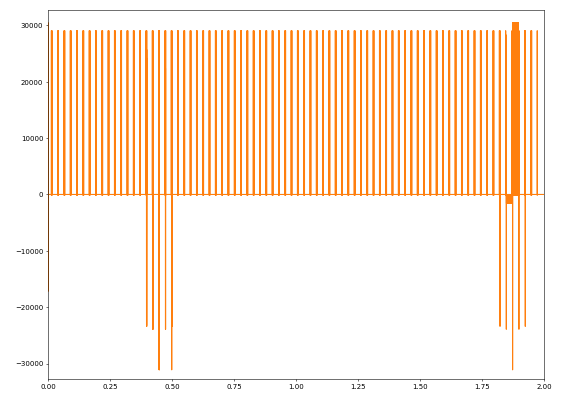

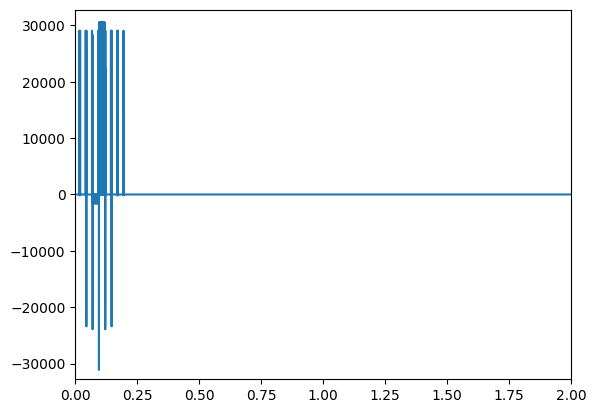

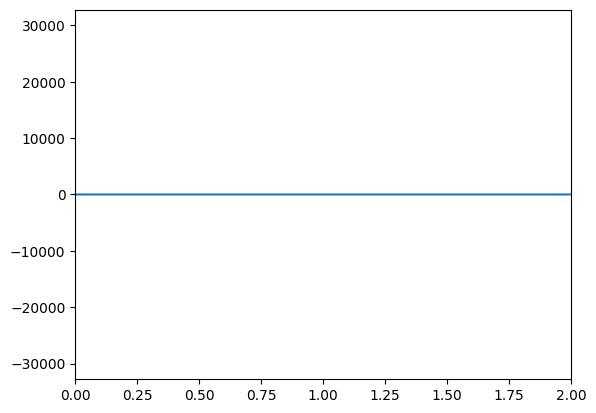

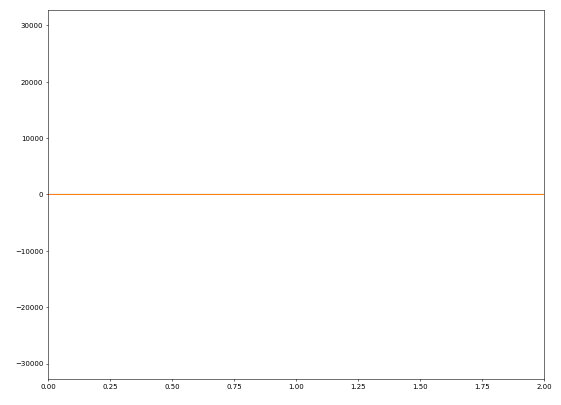

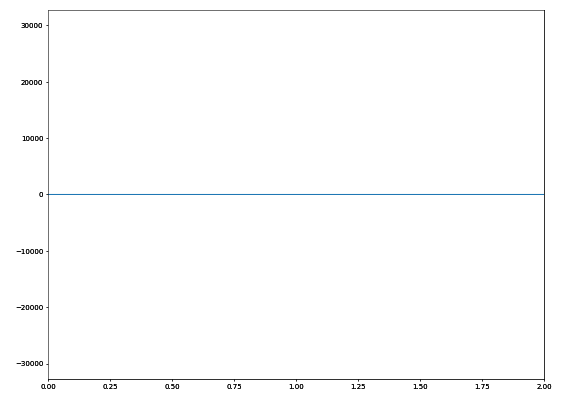

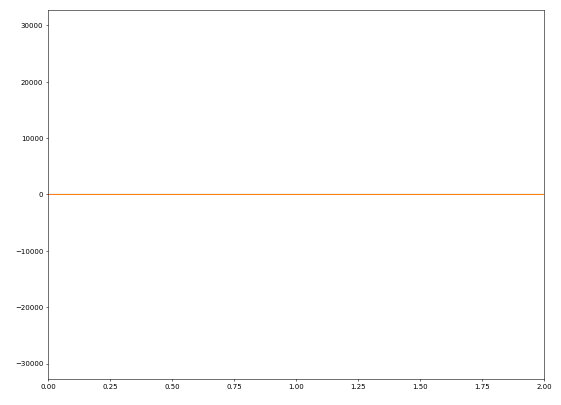


 -- stream STOPPED
DONE


Exception in thread Thread-16 (detect_drowsiness):
Traceback (most recent call last):
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Temp\ipykernel_19528\1170340309.py", line 57, in detect_drowsiness
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\ImageTk.py", line 126, in __init__
    self.__photo = tkinter.PhotoImage(**kw)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 4093, in __init__
    Image.__init__(self, 'photo', name, cnf, 

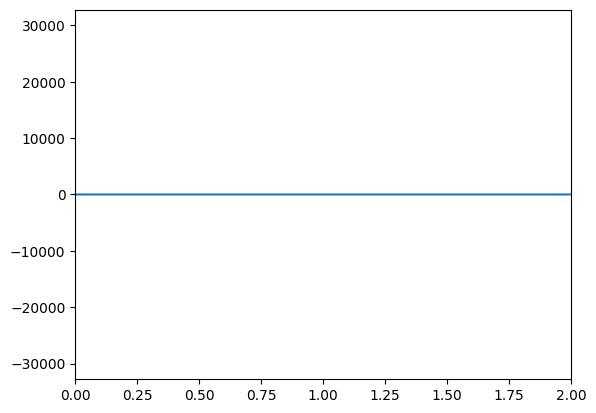

Exception in thread Thread-18 (update_mic_graph):
Traceback (most recent call last):
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Temp\ipykernel_19528\1170340309.py", line 145, in update_mic_graph
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\ImageTk.py", line 126, in __init__
    self.__photo = tkinter.PhotoImage(**kw)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 4093, in __init__
    Image.__init__(self, 'photo', name, cnf, m

Exception in thread Thread-19 (update_active_time):
Traceback (most recent call last):
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Temp\ipykernel_19528\1170340309.py", line 137, in update_active_time
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 1675, in configure
    return self._configure('configure', cnf, kw)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 1665, in _configure
    self.tk.call(_flatten((self._w, cmd)) 

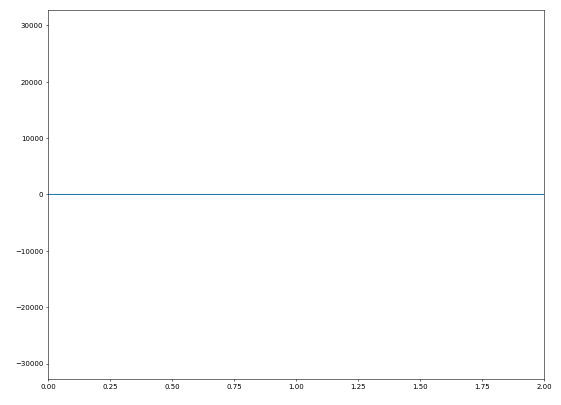

In [4]:
import tkinter as tk
import cv2
import dlib
import scipy.spatial
import numpy as np
import threading
import time
import sounddevice as sd
import matplotlib.pyplot as plt
from PIL import Image, ImageTk

# Initialize frequency and time lists
freq_list = []
time_list = []
active_start_time = None
freq_lock = threading.Lock()
time_lock = threading.Lock()

mic_device_id = 1  # Replace with your microphone's device ID


def calculate_EAR(eye):
    A = scipy.spatial.distance.euclidean(eye[1], eye[5])
    B = scipy.spatial.distance.euclidean(eye[2], eye[4])
    C = scipy.spatial.distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear


def detect_drowsiness(canvas):
    cap = cv2.VideoCapture(0)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    while True:
        _, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)
            leftEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
            rightEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
            leftEAR = calculate_EAR(leftEye)
            rightEAR = calculate_EAR(rightEye)
            EAR = (leftEAR + rightEAR) / 2
            EAR = round(EAR, 2)
            if EAR < 0.26:
                cv2.putText(frame, "Sleepy", (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                cv2.putText(frame, "Prediction: Inactive", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            else:
                cv2.putText(frame, "Prediction: Active", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(frame, "EAR: {:.2f}".format(EAR), (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        # Display the frame on the Tkinter window
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (400, 300))
        img = Image.fromarray(img)
        img = ImageTk.PhotoImage(image=img)
        canvas.create_image(0, 0, anchor=tk.NW, image=img)
        canvas.image = img

        key = cv2.waitKey(1)
        if key == ord('e'):  # Exit on 'e' key
            break
    cap.release()
    cv2.destroyAllWindows()


class SWHear(object):
    def __init__(self, device=None, start_streaming=True):
        print(" -- initializing SWHear")

        self.chunk = 4096
        self.rate = 44100
        self.tape_length = 2
        self.tape = np.empty(self.rate * self.tape_length, dtype=np.int16)
        self.sd_stream = sd.InputStream(callback=self.callback)

        if start_streaming:
            self.stream_start()

        self.keep_going = True

    def callback(self, indata, frames, time, status):
        if status:
            print(status, flush=True)
        self.tape[:-frames] = self.tape[frames:]
        self.tape[-frames:] = indata[:, 0]

    def stop(self):
        self.keep_going = False

    def stream_start(self):
        print(" -- stream started")
        self.sd_stream.start()

    def stream_stop(self):
        self.sd_stream.stop()
        print(" -- stream STOPPED")

    def close(self):
        """gently detach from things."""
        self.stream_stop()

    def tape_forever(self, plot_sec=0.1):
        t1 = 0
        keyboard.on_press_key('v', lambda _: self.stop())  # Stop the loop when 'v' is pressed
        try:
            while self.keep_going:  # Use the flag to control the loop
                if time.time() - t1 > plot_sec:
                    t1 = time.time()
                    self.tape_plot()
                    time.sleep(0.1)  # Add a small delay to avoid continuous key presses
        except:
            print(" ~~ exception (keyboard?)")
            return

    def tape_plot(self, save_as="1.png"):
        """plot what's in the tape."""
        plt.plot(np.arange(len(self.tape)) / self.rate, self.tape)
        plt.axis([0, self.tape_length, -2**16/2, 2**16/2])
        if save_as:
            t1 = time.time()
            plt.savefig(save_as, dpi=50)
            print("plotting saving took %.02f ms" % ((time.time() - t1) * 1000))
        else:
            plt.show()
            print()  # good for IPython
        plt.close('all')


def update_active_time(label):
    while True:
        if active_start_time is not None:
            duration = time.time() - active_start_time
            label.config(text=f"Your Active Voice Time: {duration:.2f} seconds")
        else:
            label.config(text="Your Active Voice Time: 0.00 seconds")
        time.sleep(0.1)


def update_mic_graph(canvas, swhear_instance):
    while swhear_instance.keep_going:
        swhear_instance.tape_plot(save_as=None)  # Live plot without saving
        img = Image.open("1.png")  # Assuming you are using save_as="1.png" in tape_plot
        img = ImageTk.PhotoImage(image=img)
        canvas.create_image(0, 0, anchor=tk.NW, image=img)
        canvas.image = img
        time.sleep(0.1)  # Add a small delay to control the update rate


root = tk.Tk()
root.title("Machine Knight")

frame = tk.Frame(root)
frame.pack()

canvas1 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas1.grid(row=0, column=0, padx=5, pady=5)

canvas2 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas2.grid(row=0, column=1, padx=5, pady=5)

canvas3 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas3.grid(row=1, column=0, padx=5, pady=5)

canvas4 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas4.grid(row=1, column=1, padx=5, pady=5)

label3 = tk.Label(canvas3, text="Your Active Voice Time: 0.00 seconds", font=("Helvetica", 12))
label3.pack(pady=10)

threading.Thread(target=detect_drowsiness, args=(canvas1,), daemon=True).start()

# Create an instance of SWHear
sw_hear = SWHear()
# Start the tape_forever thread for live microphone graph
threading.Thread(target=sw_hear.tape_forever, daemon=True).start()
# Start the thread to update the live mic graph on the canvas
threading.Thread(target=update_mic_graph, args=(canvas2, sw_hear), daemon=True).start()

threading.Thread(target=update_active_time, args=(label3,), daemon=True).start()

root.bind('e', lambda event: root.destroy())  # Exit on 'e' key

root.mainloop()

# Cleanup after closing the Tkinter window
sw_hear.close()
print("DONE")


C:\Users\MAYANK PUVVALA\AppData\Local\Temp\ipykernel_16896\1162575659.py:22: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=100, blit=True)


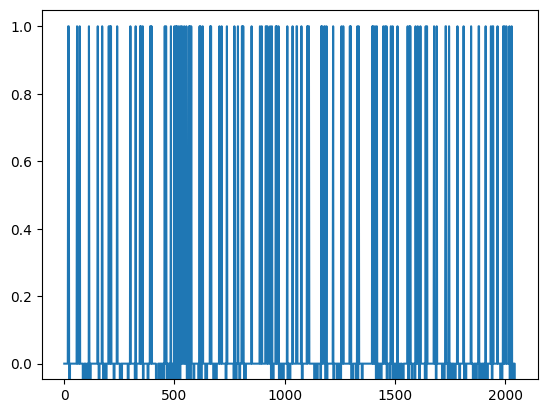

In [1]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set up PyAudio
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=44100, input=True, frames_per_buffer=1024)

# Set up matplotlib
fig, ax = plt.subplots()
x = np.arange(0, 2 * 1024, 2)
line, = ax.plot(x, np.random.rand(1024))

def update(frame):
    # Read audio data from the microphone
    data = np.frombuffer(stream.read(1024), dtype=np.int16)
    line.set_ydata(data)
    return line,

# Create an animation
ani = FuncAnimation(fig, update, interval=100, blit=True)

plt.show()

# Clean up
stream.stop_stream()
stream.close()
p.terminate()


Exception in thread Thread-6 (detect_drowsiness):
Traceback (most recent call last):
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\MAYANK PUVVALA\AppData\Local\Temp\ipykernel_16896\3706008481.py", line 61, in detect_drowsiness
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\ImageTk.py", line 126, in __init__
    self.__photo = tkinter.PhotoImage(**kw)
  File "c:\Users\MAYANK PUVVALA\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 4093, in __init__
    Image.__init__(self, 'photo', name, cnf, m

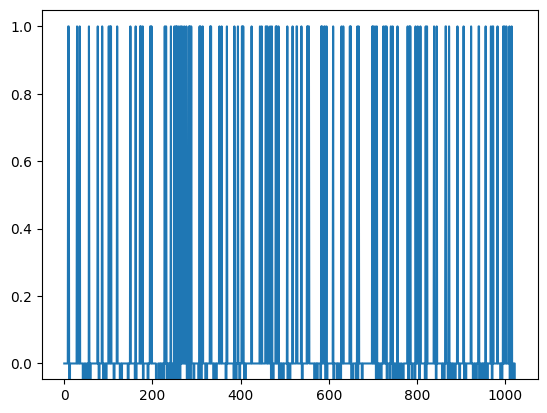

In [3]:
import tkinter as tk
import cv2
import dlib
import scipy.spatial
import numpy as np
import threading
import time
import pyaudio
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk

# Initialize PyAudio
p = pyaudio.PyAudio()

# Open stream
stream = p.open(format=pyaudio.paInt16, channels=1, rate=44100, input=True, frames_per_buffer=1024)

# Initialize frequency and time lists
freq_list = []
time_list = []
high_freq_start_time = None
freq_lock = threading.Lock()
time_lock = threading.Lock()

def calculate_EAR(eye):
    A = scipy.spatial.distance.euclidean(eye[1], eye[5])
    B = scipy.spatial.distance.euclidean(eye[2], eye[4])
    C = scipy.spatial.distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def detect_drowsiness(canvas):
    cap = cv2.VideoCapture(0)
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("D:\C downs\jupyter\shape_predictor_68_face_landmarks.dat")
    while True:
        _, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)
        for face in faces:
            landmarks = predictor(gray, face)
            leftEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
            rightEye = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
            leftEAR = calculate_EAR(leftEye)
            rightEAR = calculate_EAR(rightEye)
            EAR = (leftEAR + rightEAR) / 2
            EAR = round(EAR, 2)
            if EAR < 0.26:
                cv2.putText(frame, "Sleepy", (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
                cv2.putText(frame, "Prediction: Inactive", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            else:
                cv2.putText(frame, "Prediction: Active", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.putText(frame, "EAR: {:.2f}".format(EAR), (300, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        # Display the frame on the Tkinter window
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (400, 300))
        img = Image.fromarray(img)
        img = ImageTk.PhotoImage(image=img)
        canvas.create_image(0, 0, anchor=tk.NW, image=img)
        canvas.image = img

        key = cv2.waitKey(1)
        if key == ord('e'):  # Exit on 'e' key
            break
    cap.release()
    cv2.destroyAllWindows()

def update(frame):
    # Read audio data from the microphone
    data = np.frombuffer(stream.read(1024), dtype=np.int16)

    # Update the plot
    line.set_ydata(data)
    return line,

# Set up matplotlib
fig, ax = plt.subplots()
x = np.arange(0, 1024)
line, = ax.plot(x, np.random.rand(1024))
ani = FuncAnimation(fig, update, interval=1000, blit=True, save_count=1000)

root = tk.Tk()
root.title("Machine Knight")

frame = tk.Frame(root)
frame.pack()

canvas1 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas1.grid(row=0, column=0, padx=5, pady=5)

canvas2 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas2.grid(row=0, column=1, padx=5, pady=5)

canvas3 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas3.grid(row=1, column=0, padx=5, pady=5)

canvas4 = tk.Canvas(frame, width=400, height=300, bg='white')
canvas4.grid(row=1, column=1, padx=5, pady=5)

label3 = tk.Label(canvas3, text="Voice Count: ", font=("Helvetica", 12))
label3.pack()

threading.Thread(target=detect_drowsiness, args=(canvas1,), daemon=True).start()
# threading.Thread(target=detect_frequency, daemon=True).start()

root.bind('e', lambda event: root.destroy())  # Exit on 'e' key

root.mainloop()

# Clean up
stream.stop_stream()
stream.close()
p.terminate()
